In [3]:
# -*- coding: utf-8 -*-
"""
=== SMP_pyaudio_decimation.py =============================================


 Code-Beispiel zur Dezimation (mit / ohne Filterung) von Audio-Signalen

 Eine Audio-Datei wird blockweise eingelesen, in numpy-Arrays umgewandelt 
 dann werden Samples entnommen und die Datei wird auf
 ein Audio-Device ausgegeben.
 
===========================================================================
"""
from __future__ import division, print_function, unicode_literals

import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import scipy.signal as sig

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)

from ipywidgets import interactive
from IPython.display import Audio, display

import wave
import os

## Audio from wav-File and decimation ##
Demonstrate reading a wav-File and playing it

In [4]:
np_type = np.int16
NFFT = 128 # used for the spectrograms
R = 8# downsampling ratio - only use R = 2^k
FILTER = False  # if TRUE: filter samples before downsampling

path = '../medien'

#filename = 'ComputerBeeps2.wav'
filename = 'SpaceRipple.wav'


In [8]:
wf = wave.open(os.path.join(path, filename))
n_chan = wf.getnchannels() # number of channels in wav-file
w_samp = wf.getsampwidth() # wordlength of samples
rate_in = wf.getframerate() # samplerate in wav-file

samples_in = np.fromstring(wf.readframes(-1), dtype=np_type)#*0.9
n_samples = len(samples_in) // n_chan

print("""Channels:\t{0}\nSample width:\t{1} bytes\nOutput rate:\t{2} Hz\nInput Samples:\t{3}""".format(n_chan,  w_samp, rate_in, n_samples))

display(Audio(data=samples_in, rate=rate_in))

Channels:	1
Sample width:	2 bytes
Output rate:	11025 Hz
Input Samples:	41149


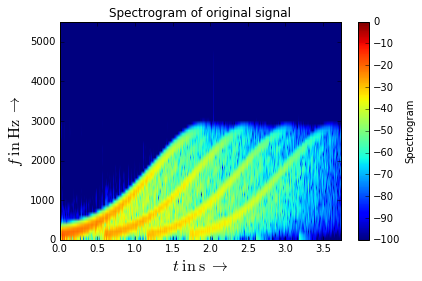

In [9]:
# ============== Create spectrogram =========================================
dbmin = -100; dbmax = 0 # Limits for log. display
win = sig.windows.kaiser(NFFT,12, sym = False) # needs NFFT and shape parameter beta
figure(1)
Pxx, freqs, bins, im = plt.specgram(samples_in / (NFFT * 2**15), NFFT=NFFT, Fs=rate_in, 
                            noverlap=NFFT/2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ylabel(r'$f \; \mathrm{in \; Hz}\;\rightarrow$', fontsize = 16)
title('Spectrogram of original signal')
xlim([0, n_samples/rate_in])
ylim([0, rate_in/2])
plt.colorbar(label = "Spectrogram")
plt.tight_layout()
plt.show()

### Downsampling and Decimation ###
Now, downsample the data with prior filtering (= decimation) or without (= downsampling)

In [16]:
R = 8
FILTER = True
STEREO = n_chan == 2
n_samp_out = int(np.ceil(n_samples / R))
rate_out = rate_in // R
print("Output rate:\t{0} Hz\nOutput samples:\t{1}".format(rate_out, n_samp_out))

# initialize arrays for samples
samples_l  = samples_r = zeros(n_samples // R) # R/L output samples (decimated)
samples_out = zeros(n_samp_out, dtype=np_type) # mono / stereo output samples (decimated)

#---------------------------------------------------------------------------
# de-interleave WAV data stream into R and L channel:
if FILTER:
    # apply decimation filter before downsampling by  a factor of R
    samples_l = sig.decimate(samples_in[0::n_chan], R, ftype='FIR')
    if STEREO:
        samples_r = sig.decimate(samples_in[1::2], R, ftype='FIR')
else:
    # downsample by R, picking every Rth sample / every 2*Rth sample (stereo)
    samples_l = samples_in[0::n_chan*R] # take every R'th sample, starting with 0
    if STEREO:
        samples_r = samples_in[1::2*R] # take every 2*R'th sample, starting with 1

# interleave R and L channel
samples_out[0::n_chan] = samples_l
if STEREO:
    samples_out[1::2] = samples_r
        
display(Audio(data=samples_out, rate=rate_out))

Output rate:	1378 Hz
Output samples:	5144


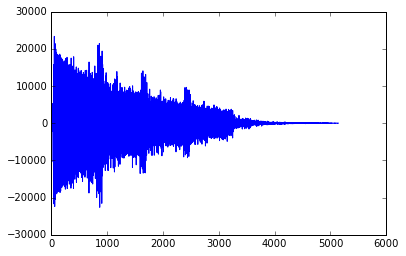

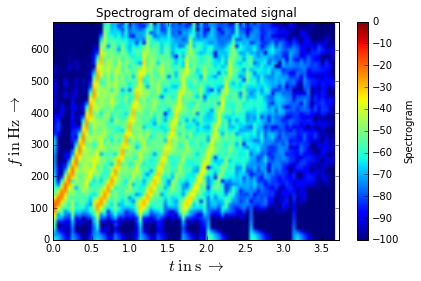

In [17]:
fig = figure(1)
plot(arange(len(samples_l)), samples_l)

# ============== Create spectrogram =========================================
dbmin = -100; dbmax = 0 # Limits for log. display
win = sig.windows.kaiser(NFFT,12, sym = False) # needs NFFT and shape parameter beta
figure(2)
Pxx, freqs, bins, im = plt.specgram(samples_out / (NFFT * 2**15), NFFT=NFFT, Fs=rate_out, 
                            noverlap=NFFT/2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ylabel(r'$f \; \mathrm{in \; Hz}\;\rightarrow$', fontsize = 16)
title('Spectrogram of decimated signal')
xlim([0, n_samp_out/rate_out])
ylim([0, rate_out/2])
plt.colorbar(label = "Spectrogram")
plt.tight_layout()
plt.show()